In [1]:
import pandas as pd
import covasim as cv
cv.options.set('jupyter', verbose=0)

Covasim 3.1.1 (2021-12-06) — © 2021 by IDM


In [2]:
germany_pop = cv.data.country_age_data.data['Germany']
pop_size_total = sum(v for v in germany_pop.values())
pop_size_total

83783942

In [3]:
# load data from European Centre for Disease Prevention and Control
datafile = 'german_data/ecfdpc_Germany.csv'
pandemic_df = pd.read_csv(datafile)
pandemic_df.head()

,Unnamed: 0,day,new_diagnoses,new_deaths,key,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,date
0,22229,0,0,0,Germany,83019213.0,Europe,NaN,2019-12-31
1,22228,1,0,0,Germany,83019213.0,Europe,NaN,2020-01-01
2,22227,2,0,0,Germany,83019213.0,Europe,NaN,2020-01-02
3,22226,3,0,0,Germany,83019213.0,Europe,NaN,2020-01-03
4,22225,4,0,0,Germany,83019213.0,Europe,NaN,2020-01-04


In [4]:
pandemic_df.tail()

,Unnamed: 0,day,new_diagnoses,new_deaths,key,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000,date
345,21884,345,23679,440,Germany,83019213.0,Europe,311.512228,2020-12-10
346,21883,346,29875,598,Germany,83019213.0,Europe,320.027124,2020-12-11
347,21882,347,28438,496,Germany,83019213.0,Europe,328.149341,2020-12-12
348,21881,348,20200,321,Germany,83019213.0,Europe,334.881517,2020-12-13
349,21880,349,16362,188,Germany,83019213.0,Europe,341.136696,2020-12-14


In [5]:
# load data from Robert-Koch-Institut
test_data_file = 'german_data/RKI_Testzahlen-gesamt.xlsx'
test_df = pd.read_excel(test_data_file, sheet_name='1_Testzahlerfassung')
test_df.head()

,Kalenderwoche,Anzahl Testungen,Positiv getestet,Positivenanteil (%),Anzahl übermittelnder Labore
0,"Bis einschließlich KW10, 2020",69493,1722,NaN,NaN
1,11/2020,129291,7502,5.802415,119.0
2,12/2020,374534,25886,6.911522,154.0
3,13/2020,377599,33139,8.776241,159.0
4,14/2020,417646,37649,9.014572,163.0


In [6]:
df = pandemic_df[['date', 'new_diagnoses', 'new_deaths']]
tests_col = [0]
for index, row in test_df.iterrows():
    tests = row['Anzahl Testungen']
    if index == 0:
        # first 10 x 7 - 2 = 68 days
        tests_col += [round(tests / 68) for i in range(68)]
    else:
        week = row['Kalenderwoche'].split('/')
        test_approx = round(tests / 7)
        if int(week[0]) == 51:
            # add the last monday with data (14.12)
            tests_col += [test_approx]
            break
        else:
            tests_col += [test_approx for i in range(7)]
assert len(pandemic_df) == len(tests_col)
df['new_tests'] = tests_col
df

/tmp/ipykernel_5162/3096579619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_tests'] = tests_col


,date,new_diagnoses,new_deaths,new_tests
0,2019-12-31,0,0,0
1,2020-01-01,0,0,1022
2,2020-01-02,0,0,1022
3,2020-01-03,0,0,1022
4,2020-01-04,0,0,1022
...,...,...,...,...
345,2020-12-10,23679,440,216577
346,2020-12-11,29875,598,216577
347,2020-12-12,28438,496,216577
348,2020-12-13,20200,321,216577


In [7]:
datafile = 'german_data/germany_covasim.csv'
df.to_csv(datafile)

In [8]:
# Define baseline parameters
number_infected = 100000
pop_size = 10000
baseline_pars = dict(
    verbose=0,
    start_day='2020-06-01',
    end_day='2020-12-01',
    pop_type='hybrid',
    pop_size=pop_size,
    scaled_pop=pop_size_total,
    pop_infected=round(pop_size * (number_infected / pop_size_total)),
    location='Germany',
    use_waning=True,  # use dynamically calculated immunity
    n_beds_hosp=80,  # https://tradingeconomics.com/germany/hospital-beds - 8 per 1000 people
    n_beds_icu=62  # https://tradingeconomics.com/germany/icu-beds - 620 per 100.000 people
)

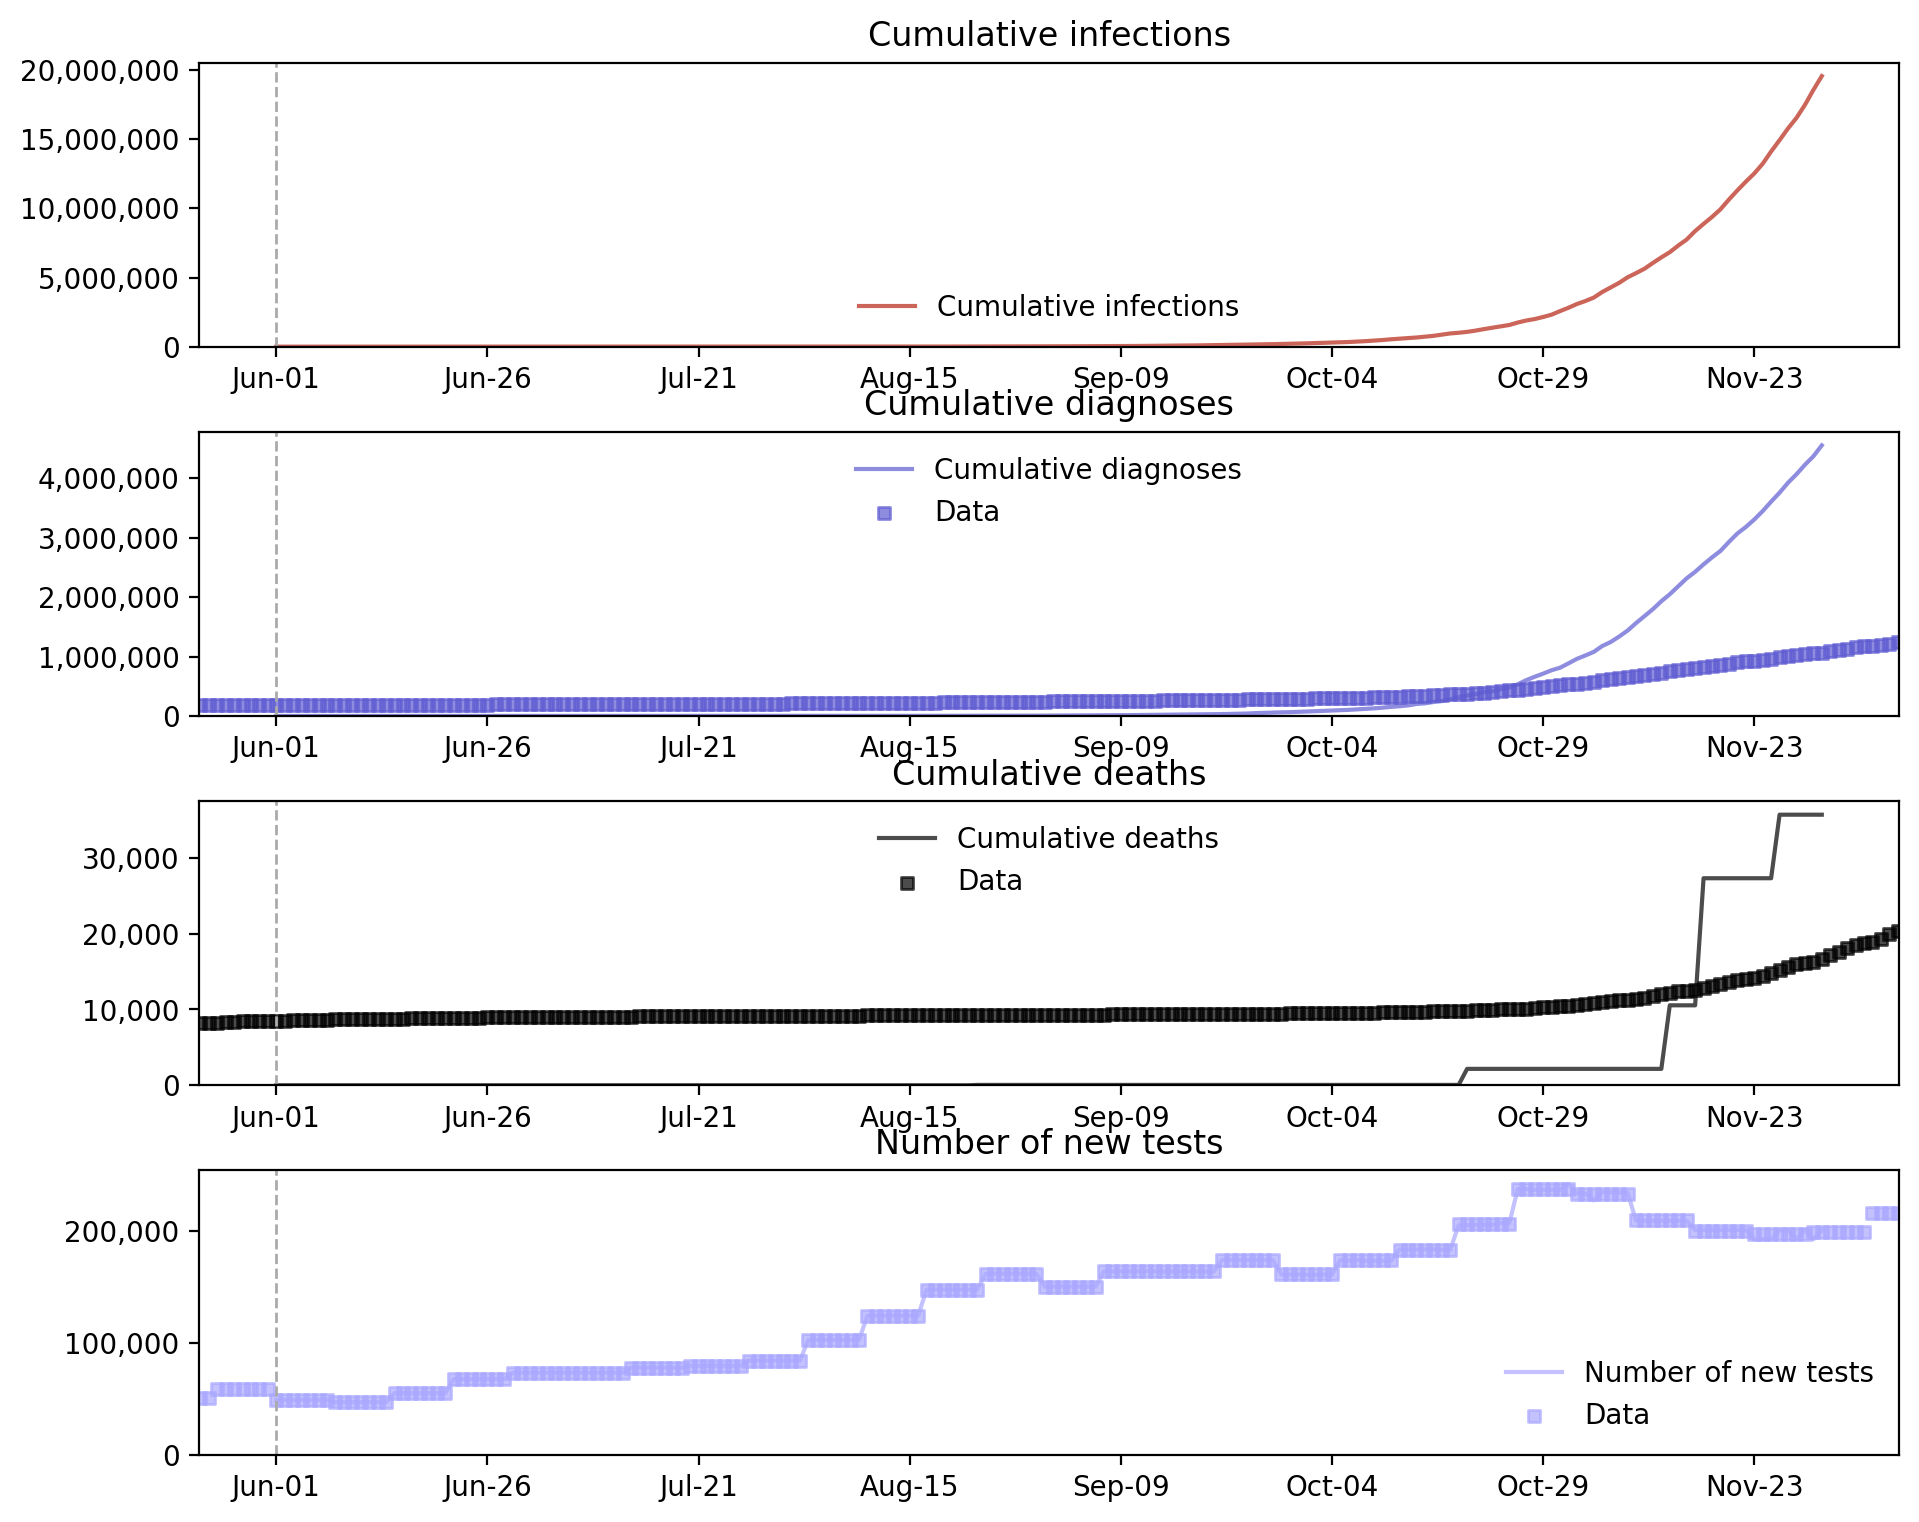

In [9]:
sim = cv.Sim(pars=baseline_pars, datafile=datafile, interventions=cv.test_num(daily_tests='data'))
sim.run()
sim.plot(to_plot=['cum_infections', 'cum_diagnoses', 'cum_deaths', 'new_tests'])

#0. cum_deaths:    1047.43326272905
#1. cum_tests:     26.818218661750063
#2. cum_diagnoses: 388.7814834248446
1463.0329648156448


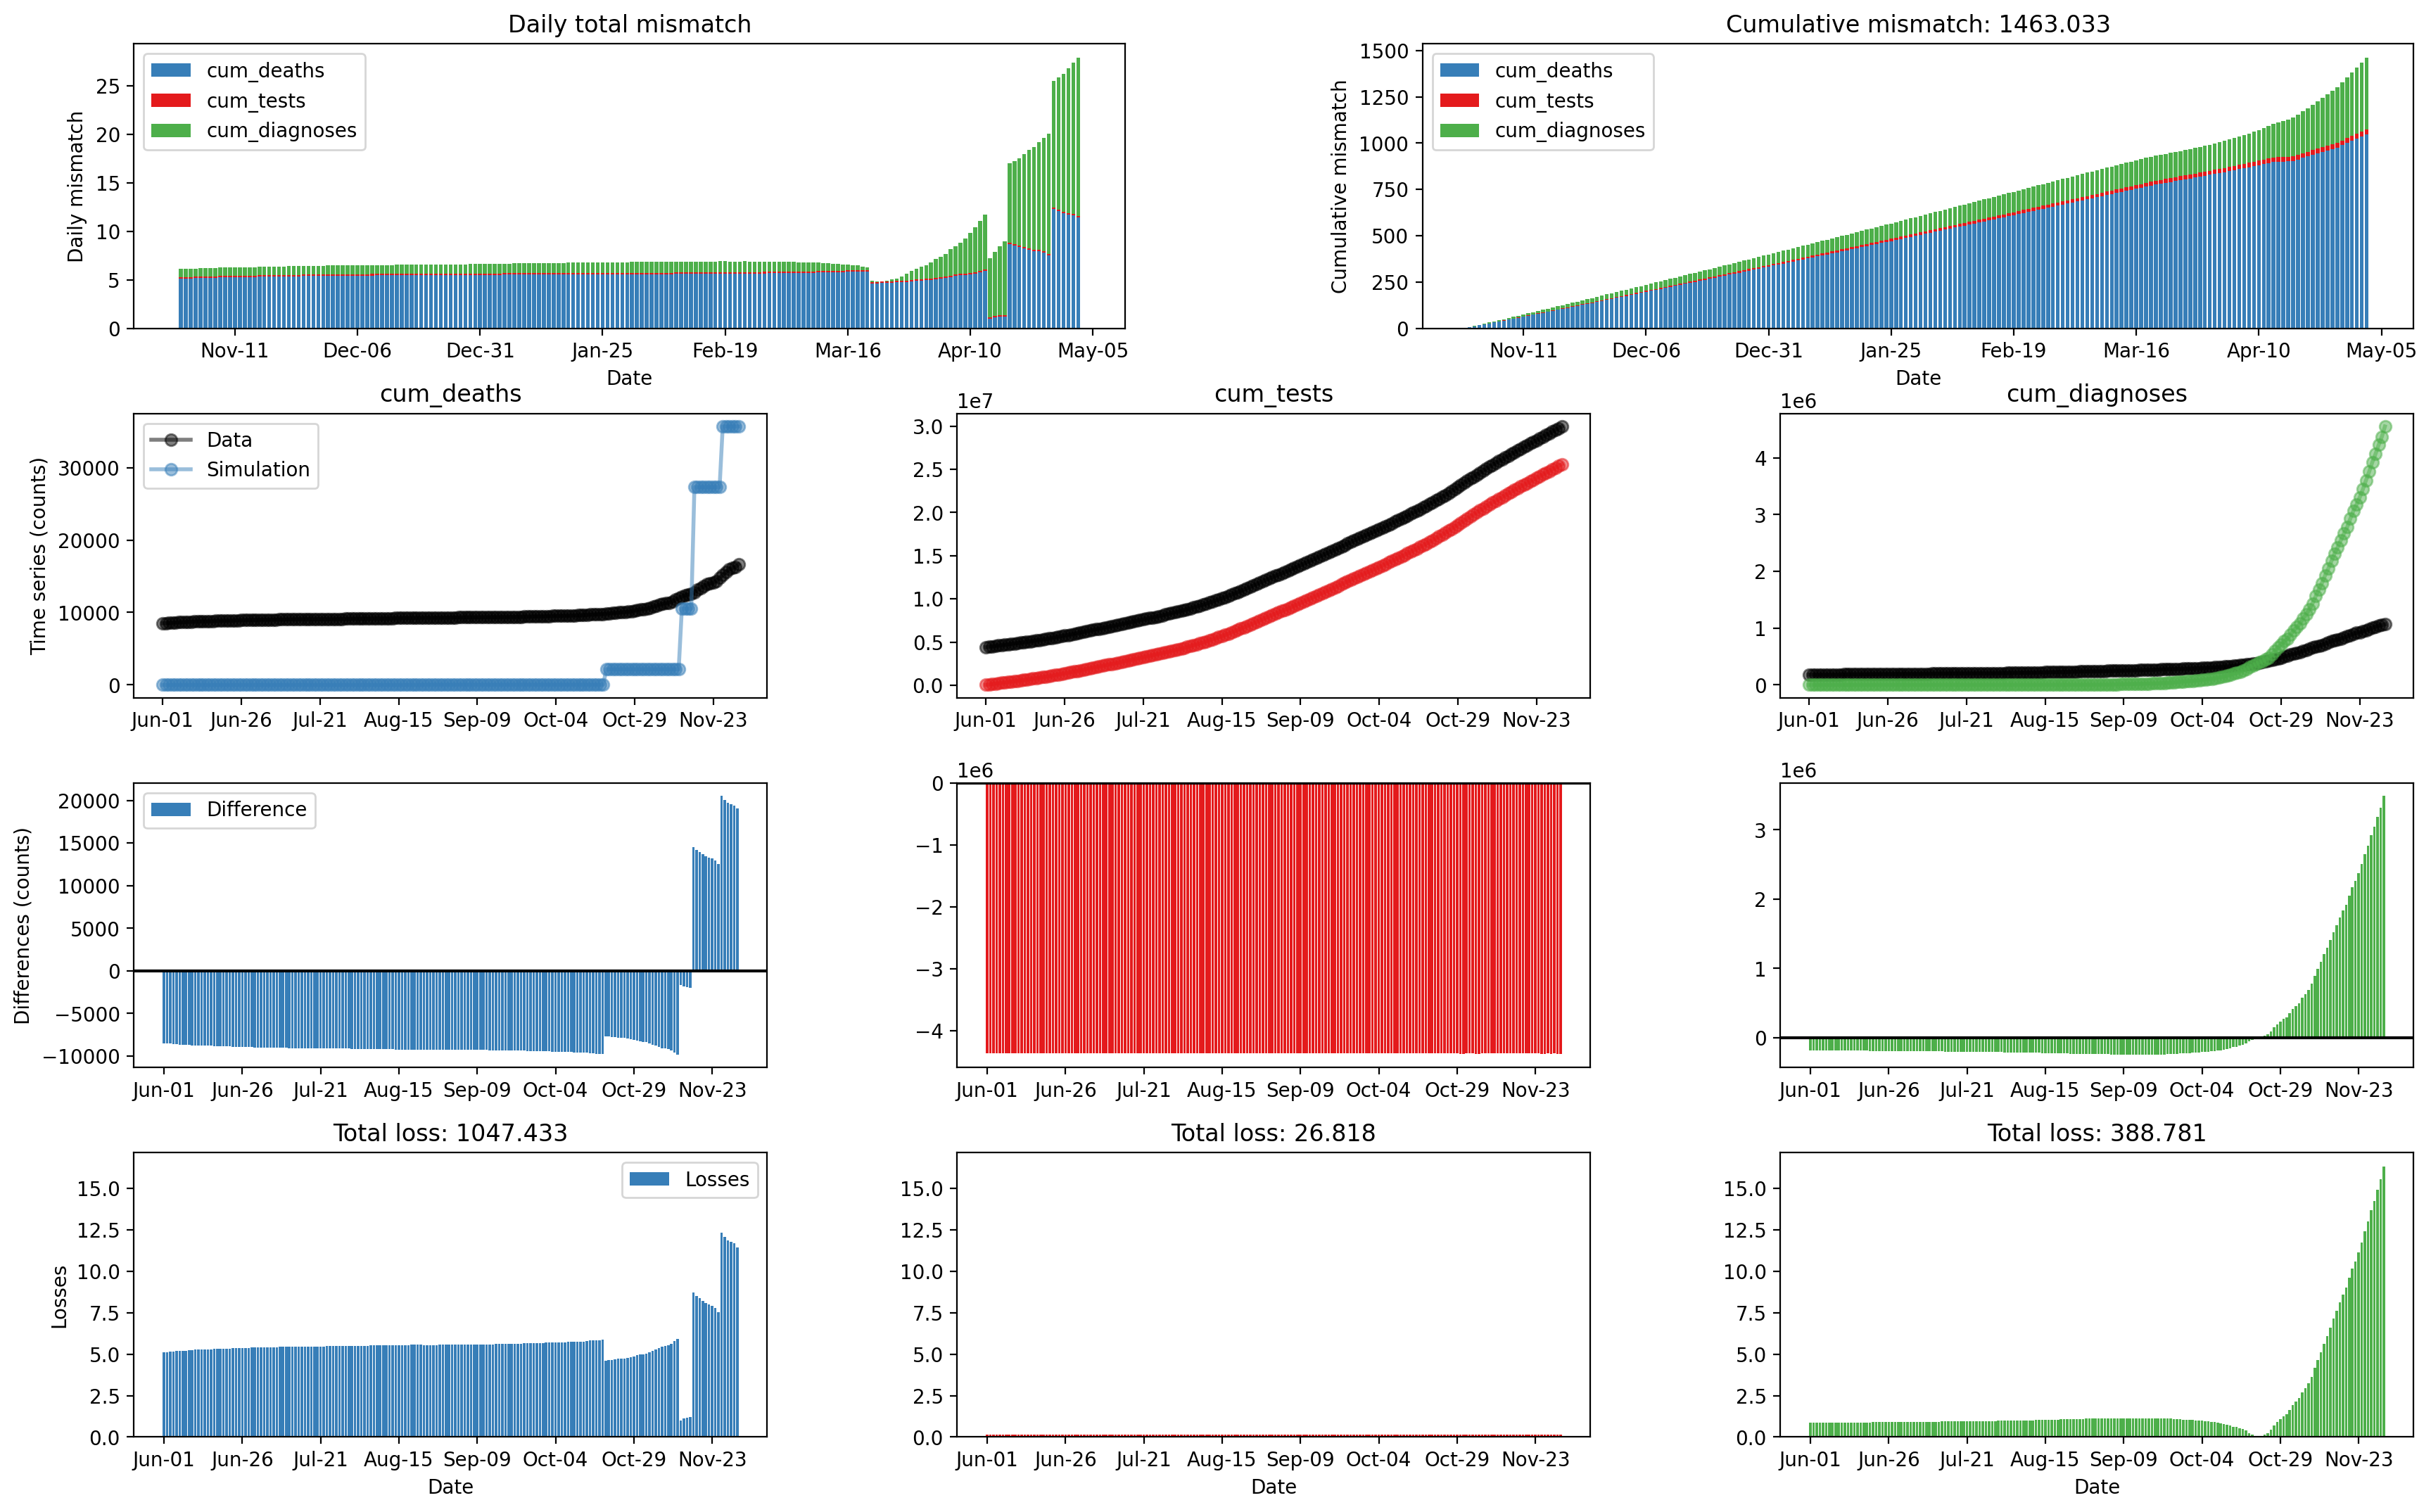

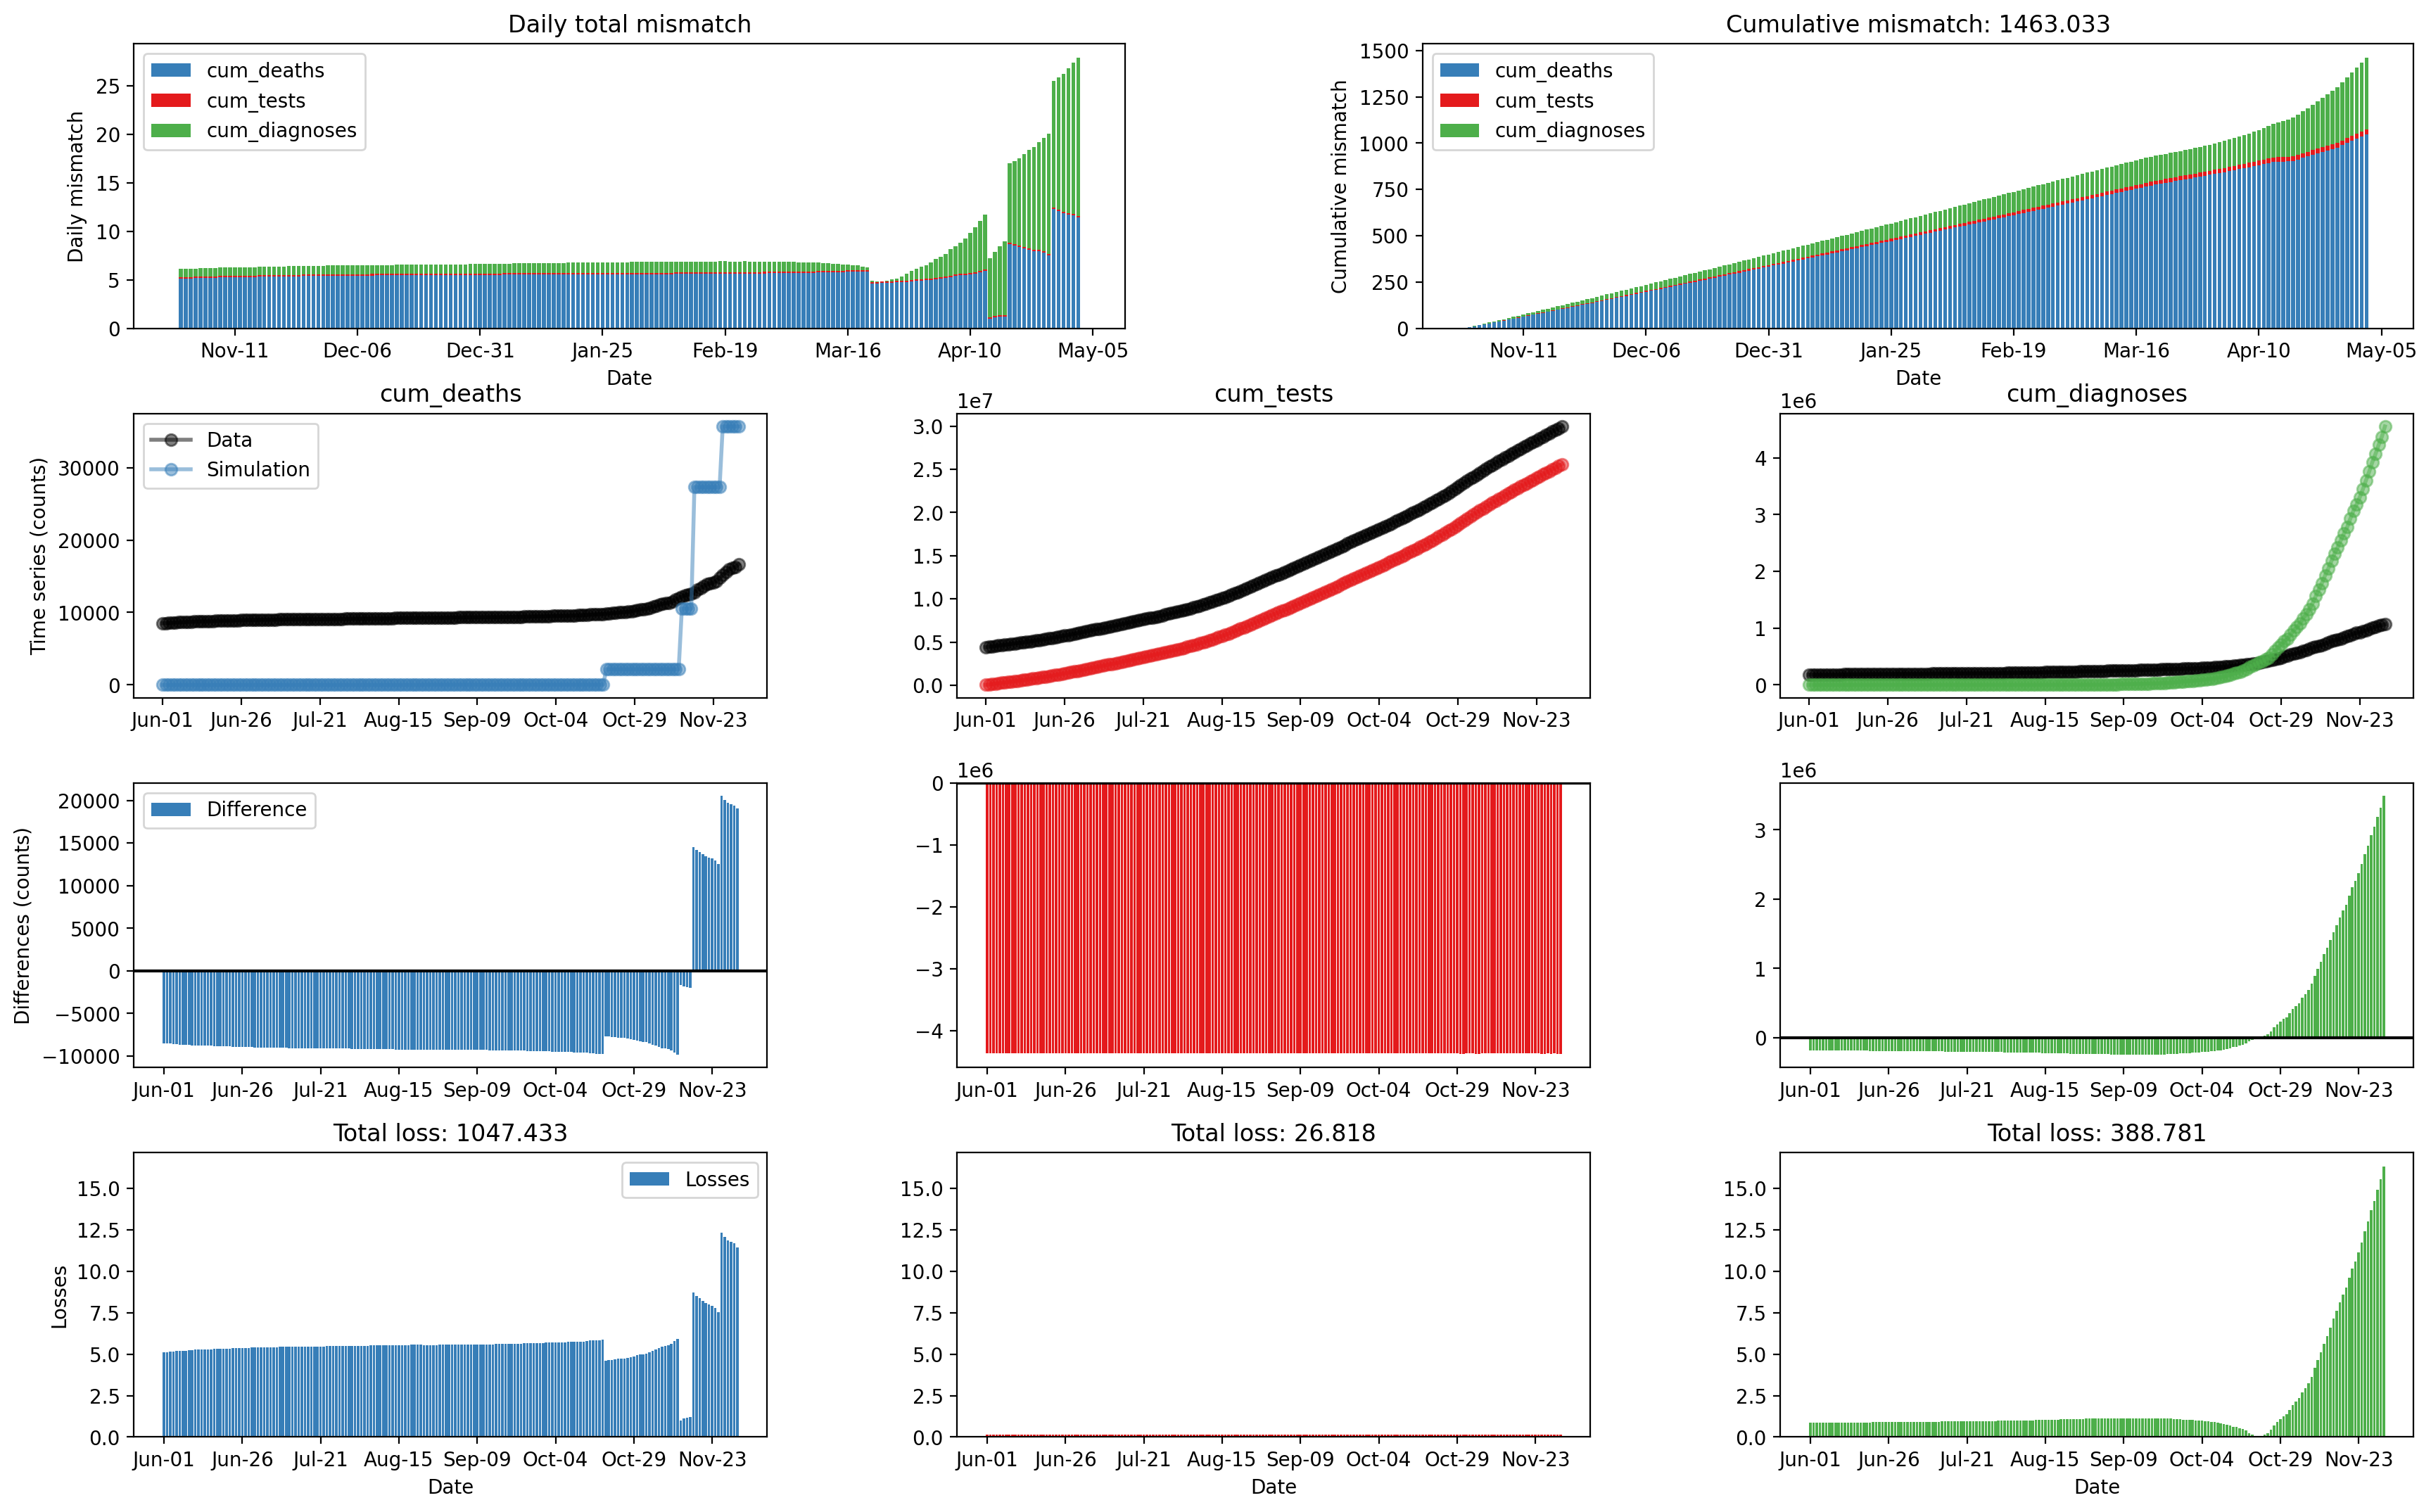

In [10]:
fit = sim.compute_fit()
print(fit.mismatches)
print(fit.mismatch)
fit.plot()